# Volumetric data processing
This is a simple demo on toy 3d data for source extraction and deconvolution using CaImAn.
For more information check demo_pipeline.ipynb which performs the complete pipeline for
2d two photon imaging data.

In [192]:
from IPython import get_ipython
import logging
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
import pickle
from scipy.ndimage import gaussian_filter
from tifffile.tifffile import imwrite

import caiman as cm
from caiman.utils.visualization import nb_view_patches3d
import caiman.source_extraction.cnmf as cnmf

try:
    if __IPYTHON__:
        get_ipython().run_line_magic('load_ext', 'autoreload')
        get_ipython().run_line_magic('autoreload', '2')
except NameError:
    pass

import bokeh.plotting as bpl
bpl.output_notebook()

logging.basicConfig(format=
                          "%(relativeCreated)12d [%(filename)s:%(funcName)20s():%(lineno)s] [%(process)d] %(message)s",
                    # filename="/tmp/caiman.log",
                    level=logging.WARNING)

from bokeh.io import output_notebook 
output_notebook()

import plotly.graph_objects as go


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Loading BokehJS ...

Loading BokehJS ...

In [193]:
from experiment_info import samples, data_dir
from experiment_info import params as p
import functions as fn
import skimage as ski


230915_FCV_GCaMP6f_F1


In [197]:
results_dir = f'results/caiman/K10'
def load_C_A_matrices(results_dir, samples):
    # A matrix specifies the positions of components
    # C matrix specifies the activity of components
    A_mats = []
    C_mats = []
    for i,samp in enumerate(samples):

        try:
            with open(f'{results_dir}/{samp}_cnm2.pkl', 'rb') as f:
                cnm = pickle.load(f)
        except FileNotFoundError:
            print(f'No file found for sample {samp}')
            continue

        A = cnm.estimates.A.toarray()
        C = cnm.estimates.C

        A_mats.append(A)
        C_mats.append(C)
    return A_mats, C_mats

A_mats, C_mats = load_C_A_matrices(results_dir, samples)

No file found for sample 230915_ORL_GCaMP6f_F1
No file found for sample 230913_U52_GCaMP6f_F2
No file found for sample 230914_U52_GCaMP6f_F2


In [194]:
with open(f'results/caiman/K10/{samples[samp_index]}_cnm2.pkl', 'rb') as f:
    cnm = pickle.load(f)

In [148]:
dir(cnm)
cnm.dims

(128, 128, 24)

In [149]:
cnm.estimates.nb_view_components_3d(image_type='max', dims=cnm.dims, axis=2);

([], [])

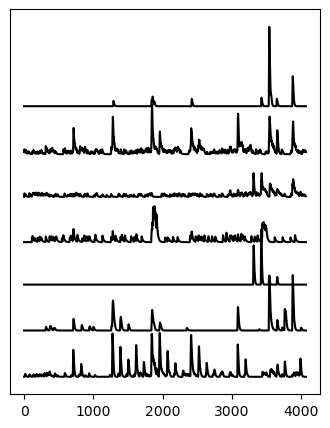

In [154]:
fig, axs = plt.subplots(1, 1, figsize=(4, 5))
for seg in range(cnm.estimates.C.shape[0]):
    
    plt.plot(cnm.estimates.C[seg,:] + seg*2, c='black')  # Offset each trace by i*3
    # axs[samp].plot(np.array(trace_mean_recontructed) + 0.1*2 , c='black')  # Offset each trace by i*3
plt.yticks([])

In [155]:
C = cnm.estimates.C
corr_mat = np.corrcoef(C)
print(corr_mat.shape)
# get the upper triangle of corr_mat
corr_mat = np.triu(corr_mat, k=1)
# get the indices of the elements that are above 0
corrs = corr_mat[np.nonzero(corr_mat)]
sns.histplot(corrs, bins=10)

(7, 7)


NameError: name 'sns' is not defined

In [ ]:
# calculate correlation between each row of cnm.estimates.C
# and each row of cnm.estimates.C
C = cnm.estimates.C
corr_mat = np.corrcoef(C)
rows = np.arange(corr_mat.shape[0])
non_diagonal_elements = [corr_mat[i, rows != i] for i in range(corr_mat.shape[0])]
corr_mat = np.array(non_diagonal_elements).T
corr_mat.shape


(8, 9)

In [ ]:
def calculate_pairwise_temporal_corrs(C1, C2):
    # compute the full correlation matrix between two matrices of temporal components
    assert C1.shape == C2.shape
    num_segments = C1.shape[0]
    corr_mat = np.zeros((num_segments, num_segments))

    for i in range(num_segments):
        for j in range(num_segments):  
            correlation, _ = pearsonr(C1[i,:], C2[j,:])
            corr_mat[i, j] = correlation
            corr_mat[j, i] = correlation  # Symmetric

    return corr_mat

In [ ]:
dir(cnm.estimates)

['A',
 'A_thr',
 'Ab',
 'Ab_dense',
 'AtA',
 'AtY_buf',
 'C',
 'CC',
 'CY',
 'C_on',
 'Cf',
 'F_dff',
 'OASISinstances',
 'R',
 'S',
 'SNR_comp',
 'W',
 'YrA',
 'Yr_buf',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'b',
 'b0',
 'bl',
 'c1',
 'center',
 'cnn_preds',
 'compute_background',
 'compute_residuals',
 'coordinates',
 'deconvolve',
 'detrend_df_f',
 'dims',
 'discarded_components',
 'ecc',
 'evaluate_components',
 'evaluate_components_CNN',
 'f',
 'filter_components',
 'g',
 'groups',
 'hv_view_components',
 'idx_components',
 'idx_components_bad',
 'ind_new',
 'lam',
 'make_color_movie',
 'manual_merge',
 'masks_2_neurofinder',
 'merge_com

In [ ]:
cnm2.estimates.C[0].shape
# cnm2.estimates.A[:,0].shape

NameError: name 'cnm2' is not defined

In [ ]:
A = cnm.estimates.A.toarray()
np.min(A), np.max(A)

(0.0, 0.04627041930923521)

In [ ]:
# STOP CLUSTER
cm.stop_server(dview=dview)